In [30]:
# Kevin Jesús Banda Azogil
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import csv
import random
from IPython.display import display, Markdown
from numba import njit, prange


## Funciones y elementos comunes a todos:

In [31]:
# Colores ANSI para resaltar texto
RED = "\033[91m"
CYAN = "\033[96m"
GREEN = "\033[92m"
RESET = "\033[0m"

# Orden deseado de los archivos
NombreArchivos = ["DataSets/tai25b.dat", "DataSets/sko90b.dat", "DataSets/tai150b.dat"]
# Costos mínimos de referencia
CostoSoluciones = {
    "DataSets/tai25b.dat": 344355646,
    "DataSets/sko90b.dat": 115534,
    "DataSets/tai150b.dat": 498896643
}

semillas = [769123, 8435, 423543, 656343, 80987]


In [32]:

def leer_archivo_y_extraer_matrices(nombre_archivo):
    with open(nombre_archivo, "r") as f:
        # Leer la primera línea para obtener `n`
        n = int(f.readline().strip())  

        # Leer el resto del archivo con np.loadtxt
        datos = np.loadtxt(f, dtype=int)

    # Dividir los datos en dos matrices
    distancia = datos[:n, :n]  # Primera parte de la matriz
    flujo = datos[n:, :n]      # Segunda parte de la matriz

    return distancia, flujo, n


# Mostrar matriz (sin cambios)
def mostrar_matriz(nombre, matriz):
    print(f"Matriz {nombre}:")
    print("\n".join(" ".join(map(str, fila)) for fila in matriz))
    print()


# Cálculo del costo usando NumPy para evitar bucles anidados
@njit
def calcular_costo(solucion, distancia, flujo, n):
    costo = 0
    for i in prange(n):
        si = solucion[i]
        for j in range(n):
            sj = solucion[j]
            costo += distancia[i][j] * flujo[si][sj]
    return costo

@njit
def calcular_costo_swap(solucion, distancia, flujo, n, i, j, costo_actual):
    si = solucion[i]
    sj = solucion[j]
    delta = 0

    for k in range(n):
        if k != i and k != j:
            sk = solucion[k]

            delta += (
                (distancia[i][k] - distancia[j][k]) * (flujo[sj][sk] - flujo[si][sk]) +
                (distancia[k][i] - distancia[k][j]) * (flujo[sk][sj] - flujo[sk][si])
            )
    
    # Diagonales y cruzados
    delta += (distancia[i][i] - distancia[j][j]) * (flujo[sj][sj] - flujo[si][si])
    delta += (distancia[i][j] - distancia[j][i]) * (flujo[sj][si] - flujo[si][sj])

    return costo_actual + delta


# Algoritmos:
Greedy:

In [33]:
def greedy_qap(distancia, flujo, n):
    ev=0
    potencialFlujo = []
    potencialDistancia = []

    #Calculo del potencial de distancia
    for j in range(n):
        potencialDistancia.append([sum(distancia[j]),j])
    potencialDistancia.sort(reverse=False, key=lambda x: x[0]) #De menor a mayor

    #Calculo del potencial de flujo
    for i in range(n):
        potencialFlujo.append([sum(flujo[i]),i])
    potencialFlujo.sort(reverse=True, key=lambda x: x[0]) #De mayor a menor
   
    asignaciones = [] # [unidad, localizacion]

    for i in range(n):
        asignaciones.append([potencialFlujo[i][1],potencialDistancia[i][1]])

    asignaciones.sort(reverse=False, key=lambda x: x[0])
    resultado = [subarray[1] for subarray in asignaciones]

    return resultado, calcular_costo(resultado, distancia, flujo, n), (ev+1)


Busqueda Local Del Primer Mejor Vecino:

In [34]:
def busqueda_local_primer_mejor(distancia, flujo, n, semilla):
    np.random.seed(semilla)
    solucion = np.arange(n)
    np.random.shuffle(solucion)
    return Algo_busqueda_local_primer_mejor(distancia, flujo, n, solucion.copy())


@njit
def Algo_busqueda_local_primer_mejor(distancia, flujo, n, solucion):
    costo = calcular_costo(solucion, distancia, flujo, n)
    ev=1 # Contamos la evaluacion inicial 
    historial_costos = []

    while True:
        mejora = False

        for i in range(n):
            for j in range(i + 1, n):
                nuevo_costo = calcular_costo_swap(solucion, distancia, flujo, n, i, j, costo)
                ev=ev+1
                if nuevo_costo < costo:
                    tmp = solucion[i]
                    solucion[i] = solucion[j]
                    solucion[j] = tmp
                    costo = nuevo_costo
                    historial_costos.append(costo)
                    mejora = True
                    break  # Salta al siguiente ciclo si se mejora
            if mejora:
                break

        if not mejora:
            break

    return solucion, costo, historial_costos, ev


Grasp:

In [35]:
def grasp_qap(distancia, flujo, n, semilla_base, puro=False):

    ev = 0
    soluciones_finales = []
    costos_finales = []
    historial_costos = []
    distancias = []

    l = max(1, int(0.1 * n))  # Parametro l como el 10% de n

    solucion_anterior = None  # Para calcular distancias
  
    for iteracion in range(5):
        semilla = semilla_base + (semilla_base * (iteracion + 1) * 103)
        solucion_greedy = construir_solucion_greedy_prob(distancia, flujo, n, semilla, l)
        
        if not puro: 
            solucion_opt, costo_opt, historial, evAux = Algo_busqueda_local_primer_mejor(distancia, flujo, n, solucion_greedy.copy())
            ev += evAux
        else:
            solucion_opt = solucion_greedy
            ev +=1
            costo_opt = calcular_costo(solucion_opt, distancia, flujo, n)

        historial_costos.append(costo_opt)


        if solucion_anterior is not None:
            distancia_hamming = np.sum(solucion_opt != solucion_anterior)
            distancias.append(distancia_hamming)
        else:
            distancias.append(0)  # Si no hay solucion anterior en la primera iteración

        solucion_anterior = solucion_opt.copy()

        soluciones_finales.append(solucion_opt)
        costos_finales.append(costo_opt)

    mejor_idx = np.argmin(costos_finales)
    return soluciones_finales[mejor_idx], costos_finales[mejor_idx], historial_costos, ev, distancias



def construir_solucion_greedy_prob(distancia, flujo, n,semilla ,l=None):
    np.random.seed(semilla)
    random.seed(semilla)

    if l is None:
        l = max(1, int(0.1 * n))

    # Calcular potenciales de distancia y flujo
    pot_dist = [[sum(distancia[j]), j] for j in range(n)]
    pot_dist.sort(key=lambda x: x[0])  # menor a mayor

    pot_flujo = [[sum(flujo[i]), i] for i in range(n)]
    pot_flujo.sort(key=lambda x: x[0], reverse=True)  # mayor a menor

    flujo_list = pot_flujo[:l]
    pot_flujo = pot_flujo[l:]
    dist_list = pot_dist[:l]
    pot_dist = pot_dist[l:]

    asignaciones = []

    while len(asignaciones) < n:
        random_f = random.choice(flujo_list)
        flujo_list.remove(random_f)

        random_d = random.choice(dist_list)
        dist_list.remove(random_d)

        asignaciones.append([random_f[1], random_d[1]])

        if pot_flujo and pot_dist:
            flujo_list.append(pot_flujo.pop(0))
            dist_list.append(pot_dist.pop(0))

    asignaciones.sort(key=lambda x: x[0])
    solucion = [loc for _, loc in asignaciones]

    return np.array(solucion)


ILS:

In [36]:
def ils_qap(distancia, flujo, n, semilla):
    np.random.seed(semilla)
    ev=0
    distancias = []
    historial_costo = []
    # Tamaño de sublista para la mutacion
    s = max(1, n // 4)

    # Generar solucion aleatoria inicial
    solucion = np.arange(n)
    np.random.shuffle(solucion)
    
    mejor_solucion, mejor_costo, historial_total, evAux = Algo_busqueda_local_primer_mejor(distancia, flujo, n, solucion.copy())
    ev=ev+evAux
    historial_costo.append(mejor_costo)

    solucion_anterior = mejor_solucion.copy()

    for _ in range(9):
        solucion_mutada = mutacion_sublista(mejor_solucion.copy(), s)
        
        nueva_solucion, nuevo_costo, historial, evAux = Algo_busqueda_local_primer_mejor(distancia, flujo, n, solucion_mutada)
        ev=ev+evAux
        historial_costo.append(nuevo_costo)


        distancia_hamming = np.sum(nueva_solucion != solucion_anterior)
        distancias.append(distancia_hamming)
        solucion_anterior = nueva_solucion.copy()

        if nuevo_costo < mejor_costo:
            mejor_solucion = nueva_solucion
            mejor_costo = nuevo_costo

        historial_total.extend(historial)

    return mejor_solucion, mejor_costo, historial_costo, ev, distancias


def mutacion_sublista(solucion, s):
    n = len(solucion)
    i = np.random.randint(0, n)
    indices = [(i + k) % n for k in range(s)]

    sublista = [solucion[idx] for idx in indices]
    np.random.shuffle(sublista)

    for idx, val in zip(indices, sublista):
        solucion[idx] = val

    return solucion


VNS:

In [37]:
def vns_qap(distancia, flujo, n, semilla):
    np.random.seed(semilla)
    ev = 0
    kmax = 5
    blmax = 10
    distancias = []
    historial_costo=[]

    solucion_actual = np.arange(n)
    np.random.shuffle(solucion_actual)

    costo_actual = calcular_costo(solucion_actual, distancia, flujo, n)
    historial_costo.append(costo_actual)

    bl_count = 0
    k = 1

    while bl_count < blmax:
        if k > kmax:
            k = 1  
            # no repetir, cortar el bucle

        s = int(n / (9 - k))  
        vecino = mutacion_sublista(solucion_actual.copy(), s)

        solucion_nueva, costo_nuevo, historial, evAux = Algo_busqueda_local_primer_mejor(distancia, flujo, n, vecino)
        historial_costo.append(costo_nuevo)

        ev += evAux
        bl_count += 1  

        if costo_nuevo < costo_actual:
            solucion_actual = solucion_nueva
            costo_actual = costo_nuevo
            k = 1
        else:
            k += 1

        distancia_hamming = np.sum(solucion_actual != solucion_nueva)
        distancias.append(distancia_hamming)

    return solucion_actual, costo_actual, historial_costo, ev, distancias


def mutacion_sublista(solucion, s):
    n = len(solucion)
    i = np.random.randint(0, n)
    indices = [(i + k) % n for k in range(s)]

    sublista = [solucion[idx] for idx in indices]
    np.random.shuffle(sublista)

    for idx, val in zip(indices, sublista):
        solucion[idx] = val

    return solucion


# Ejecución:

In [38]:
# Contador de ejecuciones y almacenamiento en memoria
contador_algoritmos_ejecutados = 0
resultados_en_memoria = []
estadisticas_chc_por_dataset = {}  # Clave: nombre_archivo, Valor: dict con métricas y datos


# Crear encabezado del CSV sin historial de costos
def crear_encabezado_csv():
    with open("resultados_P2.csv", "w", newline="") as archivo_csv:
        escritor_csv = csv.writer(archivo_csv)
        escritor_csv.writerow([
            "Archivo", "Algoritmo", "Semilla", 
            "Costo", "Costo Optimo", "Evaluaciones"
        ])

# Escribir resultados en el CSV (sin historial), pero mantenerlo en memoria
def escribir_resultados(archivo, algoritmo, semilla, mejor_solucion, mejor_costo, costo_optimo, historial_costos, evaluaciones):
    global contador_algoritmos_ejecutados, resultados_en_memoria

    # Resultado completo para análisis en Jupyter
    fila_memoria = {
        "Archivo": archivo,
        "Algoritmo": algoritmo,
        "Semilla": semilla,
        "Mejor Solucion": mejor_solucion,
        "Costo": mejor_costo,
        "Costo Optimo": costo_optimo,
        "Historial de Costos": historial_costos,  # solo en memoria
        "Evaluaciones": evaluaciones
    }
    resultados_en_memoria.append(fila_memoria)

    # Resultado reducido para archivo CSV
    fila_csv = {
        "Archivo": archivo,
        "Algoritmo": algoritmo,
        "Semilla": semilla,
        "Costo": mejor_costo,
        "Costo Optimo": costo_optimo,
        "Evaluaciones": evaluaciones
    }

    with open("resultados_P2.csv", "a", newline="") as archivo_csv:
        escritor_csv = csv.DictWriter(archivo_csv, fieldnames=fila_csv.keys())
        escritor_csv.writerow(fila_csv)
        archivo_csv.flush()

    contador_algoritmos_ejecutados += 1


def ejecutar_algoritmos(nombre_archivo, distancia, flujo, n, semilla, costo_optimo):
    try:
        mejor_solucion, mejor_costo, historial_costos, evaluaciones = busqueda_local_primer_mejor(distancia, flujo, n, semilla)
        escribir_resultados(nombre_archivo, "Busqueda Local del Primer Vecino", semilla, mejor_solucion, mejor_costo, costo_optimo, historial_costos, evaluaciones)

        mejor_solucion, mejor_costo,historial_costos ,evaluaciones, distancias_Grasp = grasp_qap(distancia, flujo, n, semilla)
        escribir_resultados(nombre_archivo, "Busqueda GRASP (BL)", semillas[0], mejor_solucion, mejor_costo, costo_optimo, historial_costos, evaluaciones)

        # Gasp greedy sin bl
        mejor_solucion, mejor_costo,historial_costos ,evaluaciones, distancias_Grasp = grasp_qap(distancia, flujo, n, semilla, True)
        escribir_resultados(nombre_archivo, "Busqueda GRASP (Puro)", semillas[0], mejor_solucion, mejor_costo, costo_optimo, historial_costos, evaluaciones)

        mejor_solucion, mejor_costo, historial_costos, evaluaciones, distancias_ILS = ils_qap(distancia, flujo, n, semilla)
        escribir_resultados(nombre_archivo, "Busqueda ILS", semillas[0], mejor_solucion, mejor_costo, costo_optimo, historial_costos, evaluaciones)

        mejor_solucion, mejor_costo, historial_costos, evaluaciones, distacias_VNS = vns_qap(distancia, flujo, n, semilla)
        escribir_resultados(nombre_archivo, "Busqueda VNS", semilla, mejor_solucion, mejor_costo, costo_optimo, historial_costos, evaluaciones)



    except Exception as e:
        print(f"Ocurrió un error: {e}")



In [39]:
for i, nombre_archivo in enumerate(NombreArchivos):
    print(f"{GREEN}Ejecucion de {nombre_archivo} iniciada{RESET}")

    if i == 0:
        crear_encabezado_csv()

    distancia, flujo, n = leer_archivo_y_extraer_matrices(nombre_archivo)

    mejor_solucion, mejor_costo, evaluaciones = greedy_qap(distancia, flujo, n)
    escribir_resultados(nombre_archivo, "Greedy", "N/A", mejor_solucion, mejor_costo, CostoSoluciones[nombre_archivo], [], evaluaciones)


    for semilla in semillas:
        ejecutar_algoritmos(nombre_archivo, distancia, flujo, n, semilla, CostoSoluciones[nombre_archivo])

    print(f"{RED}Ejecucion de {nombre_archivo} finalizada{RESET}")


Ejecucion de DataSets/tai25b.dat iniciada
Ejecucion de DataSets/tai25b.dat finalizada
Ejecucion de DataSets/sko90b.dat iniciada
Ejecucion de DataSets/sko90b.dat finalizada
Ejecucion de DataSets/tai150b.dat iniciada
Ejecucion de DataSets/tai150b.dat finalizada


In [40]:
def formatear_numero(valor, decimales=0):
    if valor is None or valor == "-" or (isinstance(valor, float) and np.isnan(valor)):
        return "-"
    try:
        valor_num = float(valor)
    except (ValueError, TypeError):
        return str(valor)  # si no es numérico, devuelve tal cual
    
    s = f"{valor_num:,.{decimales}f}"
    s = s.replace(",", "X").replace(".", ",").replace("X", ".")
    return s



def leer_y_representar_resultados_desde_memoria(resultados, representarHistorial=True):
    df = pd.DataFrame(resultados)
    if df.empty:
        print("No hay resultados para mostrar.")
        return

    df["Semilla"] = df["Semilla"].apply(lambda x: int(x) if str(x).isdigit() else "N/A")
    df["Archivo"] = pd.Categorical(df["Archivo"], categories=NombreArchivos, ordered=True)
    df = df.sort_values(by=["Archivo", "Algoritmo", "Semilla"])

    for archivo in NombreArchivos:
        nombre_simple = archivo.split("/")[-1].replace(".dat", "")
        df_archivo = df[df["Archivo"] == archivo]
        if df_archivo.empty:
            continue

        display(Markdown(f"## 📁 Dataset: **{nombre_simple}**"))

        for algoritmo, grupo_alg in df_archivo.groupby("Algoritmo", sort=False):
            display(Markdown(f"### 🧬 Algoritmo: **{algoritmo}** - Dataset: **{nombre_simple}**"))

            # Construcción de la tabla tipo "Tabla 1.1"
            filas = []
            for _, fila in grupo_alg.iterrows():
                filas.append([
                    f"Semilla {fila['Semilla']}",
                    formatear_numero(fila["Costo"]),
                    formatear_numero(fila["Evaluaciones"])
                ])

            media_costo = grupo_alg["Costo"].mean()
            media_ev = grupo_alg["Evaluaciones"].mean()
            std_costo = grupo_alg["Costo"].std()
            std_ev = grupo_alg["Evaluaciones"].std()

            filas.append([
                "Media",
                formatear_numero(media_costo, 2),
                formatear_numero(media_ev, 2)
            ])
            filas.append([
                "Des.Tip. (σ)",
                formatear_numero(std_costo, 2),
                formatear_numero(std_ev, 2)
            ])
            
            tabla = pd.DataFrame(filas, columns=["Ejecución", "Costo", "#Evaluaciones"])
            display(tabla)


            # Gráfica
            hay_historial = any(
                isinstance(hist, list) and len(hist) > 0
                for hist in grupo_alg["Historial de Costos"]
            )

            if hay_historial and representarHistorial:
                display(Markdown(f"📈 **Evolución del Costo - {algoritmo}**"))
                plt.figure(figsize=(10, 5))
                for _, fila in grupo_alg.iterrows():
                    historial = fila["Historial de Costos"]
                    if isinstance(historial, list) and len(historial) > 0:
                        plt.plot(historial, label=f"Semilla {fila['Semilla']}")
                if archivo in CostoSoluciones:
                    plt.axhline(y=CostoSoluciones[archivo], color='red', linestyle='--', label=f"Costo Óptimo: {CostoSoluciones[archivo]}")
                plt.xlabel("Iteraciones")
                plt.ylabel("Costo")
                plt.title(f"{nombre_simple} - {algoritmo}")
                plt.legend()
                plt.grid(True)
                plt.tight_layout()
                plt.show()


In [41]:
df = pd.DataFrame(resultados_en_memoria)
print(df["Archivo"].unique())

leer_y_representar_resultados_desde_memoria(resultados_en_memoria, representarHistorial=False)


['DataSets/tai25b.dat' 'DataSets/sko90b.dat' 'DataSets/tai150b.dat']


## 📁 Dataset: **tai25b**

### 🧬 Algoritmo: **Busqueda GRASP (BL)** - Dataset: **tai25b**

,Ejecución,Costo,#Evaluaciones
0,Semilla 769123,348.466.729,37.217
1,Semilla 769123,344.594.778,33.958
2,Semilla 769123,348.409.095,37.244
3,Semilla 769123,350.871.189,31.645
4,Semilla 769123,345.626.201,37.365
5,Media,"347.593.598,40","35.485,80"
6,Des.Tip. (σ),"2.501.677,85","2.583,87"


### 🧬 Algoritmo: **Busqueda GRASP (Puro)** - Dataset: **tai25b**

,Ejecución,Costo,#Evaluaciones
0,Semilla 769123,779.942.000,5
1,Semilla 769123,730.976.392,5
2,Semilla 769123,720.458.127,5
3,Semilla 769123,731.424.868,5
4,Semilla 769123,681.630.865,5
5,Media,"728.886.450,40","5,00"
6,Des.Tip. (σ),"35.077.084,94","0,00"


### 🧬 Algoritmo: **Busqueda ILS** - Dataset: **tai25b**

,Ejecución,Costo,#Evaluaciones
0,Semilla 769123,394.964.292,25.898
1,Semilla 769123,376.641.262,19.202
2,Semilla 769123,363.667.045,22.718
3,Semilla 769123,344.904.410,28.628
4,Semilla 769123,348.599.358,31.956
5,Media,"365.755.273,40","25.680,40"
6,Des.Tip. (σ),"20.646.526,05","4.971,53"


### 🧬 Algoritmo: **Busqueda Local del Primer Vecino** - Dataset: **tai25b**

,Ejecución,Costo,#Evaluaciones
0,Semilla 8435,382.736.549,4.979
1,Semilla 80987,435.271.658,5.671
2,Semilla 423543,367.030.385,5.876
3,Semilla 656343,368.379.802,7.706
4,Semilla 769123,402.914.653,4.762
5,Media,"391.266.609,40","5.798,80"
6,Des.Tip. (σ),"28.531.051,85","1.162,62"


### 🧬 Algoritmo: **Busqueda VNS** - Dataset: **tai25b**

,Ejecución,Costo,#Evaluaciones
0,Semilla 8435,380.034.200,22.196
1,Semilla 80987,368.292.789,18.580
2,Semilla 423543,365.884.856,18.464
3,Semilla 656343,347.174.156,21.561
4,Semilla 769123,385.349.045,18.901
5,Media,"369.347.009,20","19.940,40"
6,Des.Tip. (σ),"14.790.322,01","1.790,59"


### 🧬 Algoritmo: **Greedy** - Dataset: **tai25b**

,Ejecución,Costo,#Evaluaciones
0,Semilla N/A,913.427.707,1
1,Media,"913.427.707,00","1,00"
2,Des.Tip. (σ),-,-


## 📁 Dataset: **sko90b**

### 🧬 Algoritmo: **Busqueda GRASP (BL)** - Dataset: **sko90b**

,Ejecución,Costo,#Evaluaciones
0,Semilla 769123,116.764,3.256.778
1,Semilla 769123,117.050,3.202.668
2,Semilla 769123,117.140,3.215.528
3,Semilla 769123,116.654,3.307.783
4,Semilla 769123,117.512,3.236.275
5,Media,"117.024,00","3.243.806,40"
6,Des.Tip. (σ),"337,93","41.261,44"


### 🧬 Algoritmo: **Busqueda GRASP (Puro)** - Dataset: **sko90b**

,Ejecución,Costo,#Evaluaciones
0,Semilla 769123,135.846,5
1,Semilla 769123,136.134,5
2,Semilla 769123,135.842,5
3,Semilla 769123,135.082,5
4,Semilla 769123,135.584,5
5,Media,"135.697,60","5,00"
6,Des.Tip. (σ),"395,34","0,00"


### 🧬 Algoritmo: **Busqueda ILS** - Dataset: **sko90b**

,Ejecución,Costo,#Evaluaciones
0,Semilla 769123,116.652,3.341.913
1,Semilla 769123,116.480,3.188.543
2,Semilla 769123,116.124,2.644.982
3,Semilla 769123,116.702,2.632.424
4,Semilla 769123,116.514,3.219.923
5,Media,"116.494,40","3.005.557,00"
6,Des.Tip. (σ),"226,78","339.784,71"


### 🧬 Algoritmo: **Busqueda Local del Primer Vecino** - Dataset: **sko90b**

,Ejecución,Costo,#Evaluaciones
0,Semilla 8435,117.190,789.150
1,Semilla 80987,117.038,754.970
2,Semilla 423543,117.030,659.400
3,Semilla 656343,118.296,582.754
4,Semilla 769123,117.108,566.027
5,Media,"117.332,40","670.460,20"
6,Des.Tip. (σ),"542,51","99.937,70"


### 🧬 Algoritmo: **Busqueda VNS** - Dataset: **sko90b**

,Ejecución,Costo,#Evaluaciones
0,Semilla 8435,116.640,1.780.307
1,Semilla 80987,116.356,2.370.082
2,Semilla 423543,116.228,2.503.137
3,Semilla 656343,117.008,2.430.388
4,Semilla 769123,116.170,2.303.192
5,Media,"116.480,40","2.277.421,20"
6,Des.Tip. (σ),"346,18","287.540,93"


### 🧬 Algoritmo: **Greedy** - Dataset: **sko90b**

,Ejecución,Costo,#Evaluaciones
0,Semilla N/A,136.080,1
1,Media,"136.080,00","1,00"
2,Des.Tip. (σ),-,-


## 📁 Dataset: **tai150b**

### 🧬 Algoritmo: **Busqueda GRASP (BL)** - Dataset: **tai150b**

,Ejecución,Costo,#Evaluaciones
0,Semilla 769123,508.342.309,23.272.476
1,Semilla 769123,510.150.395,25.602.774
2,Semilla 769123,508.182.871,24.773.350
3,Semilla 769123,509.266.778,24.669.019
4,Semilla 769123,508.553.354,23.319.110
5,Media,"508.899.141,40","24.327.345,80"
6,Des.Tip. (σ),"812.937,08","1.008.918,62"


### 🧬 Algoritmo: **Busqueda GRASP (Puro)** - Dataset: **tai150b**

,Ejecución,Costo,#Evaluaciones
0,Semilla 769123,645.333.882,5
1,Semilla 769123,636.181.089,5
2,Semilla 769123,649.774.776,5
3,Semilla 769123,643.472.570,5
4,Semilla 769123,637.164.223,5
5,Media,"642.385.308,00","5,00"
6,Des.Tip. (σ),"5.705.973,33","0,00"


### 🧬 Algoritmo: **Busqueda ILS** - Dataset: **tai150b**

,Ejecución,Costo,#Evaluaciones
0,Semilla 769123,502.716.427,22.950.416
1,Semilla 769123,503.765.778,24.784.597
2,Semilla 769123,507.771.890,23.533.538
3,Semilla 769123,508.225.652,25.554.335
4,Semilla 769123,509.566.855,23.817.049
5,Media,"506.409.320,40","24.127.987,00"
6,Des.Tip. (σ),"2.989.626,20","1.037.103,04"


### 🧬 Algoritmo: **Busqueda Local del Primer Vecino** - Dataset: **tai150b**

,Ejecución,Costo,#Evaluaciones
0,Semilla 8435,510.018.713,6.482.436
1,Semilla 80987,513.780.289,5.159.328
2,Semilla 423543,509.920.849,6.304.166
3,Semilla 656343,512.367.226,5.643.033
4,Semilla 769123,509.412.789,4.465.263
5,Media,"511.099.973,20","5.610.845,20"
6,Des.Tip. (σ),"1.883.883,65","830.305,16"


### 🧬 Algoritmo: **Busqueda VNS** - Dataset: **tai150b**

,Ejecución,Costo,#Evaluaciones
0,Semilla 8435,512.658.799,13.538.759
1,Semilla 80987,512.457.158,13.300.430
2,Semilla 423543,508.210.225,14.918.236
3,Semilla 656343,507.700.630,17.688.571
4,Semilla 769123,509.618.860,17.537.008
5,Media,"510.129.134,40","15.396.600,80"
6,Des.Tip. (σ),"2.326.968,19","2.115.940,18"


### 🧬 Algoritmo: **Greedy** - Dataset: **tai150b**

,Ejecución,Costo,#Evaluaciones
0,Semilla N/A,653.315.921,1
1,Media,"653.315.921,00","1,00"
2,Des.Tip. (σ),-,-


In [42]:

def tabla_resultados_globales(resultados, nombre_algoritmos=None):
    df = pd.DataFrame(resultados)
    if df.empty:
        print("No hay resultados para mostrar.")
        return

    df["Archivo"] = df["Archivo"].apply(lambda x: x.split("/")[-1].replace(".dat", ""))
    df["Costo"] = pd.to_numeric(df["Costo"], errors='coerce')

    if nombre_algoritmos is None:
        nombre_algoritmos = df["Algoritmo"].unique().tolist()

    nombre_algoritmos = [alg for alg in nombre_algoritmos if alg.lower() != "greedy"]


    modelos = ["Óptimo", "Greedy"] + nombre_algoritmos

    columnas = ["Mejor", "Media", "Peor", "σ"]


    for archivo in NombreArchivos:
        ds = archivo.split("/")[-1].replace(".dat", "")
        if ds not in df["Archivo"].values:
            continue
        # resto del código usando ds...

        tabla_resumen = pd.DataFrame(index=modelos, columns=columnas)
        
        display(Markdown(f"## 📁 Resumen: **{ds}**"))


        # Valor óptimo
        opt_val = CostoSoluciones.get(f"DataSets/{ds}.dat", "-")
        tabla_resumen.loc["Óptimo", "Media"] = formatear_numero(opt_val)
        tabla_resumen.loc["Óptimo", ["Mejor", "Peor", "σ"]] = "-"

        # Valor Greedy (único en Media, otros '-')
        greedy_subset = df[(df["Archivo"] == ds) & (df["Algoritmo"].str.lower() == "greedy")]
        if not greedy_subset.empty:
            media_greedy = greedy_subset["Costo"].mean()
            tabla_resumen.loc["Greedy", "Media"] = formatear_numero(media_greedy)
            tabla_resumen.loc["Greedy", ["Mejor", "Peor", "σ"]] = "-"
        else:
            tabla_resumen.loc["Greedy"] = "-"

        # Otros algoritmos
        for alg in nombre_algoritmos:
            if alg.lower() == "greedy":
                continue  # ya está tratado arriba

            subset = df[(df["Archivo"] == ds) & (df["Algoritmo"] == alg)]
            if subset.empty:
                tabla_resumen.loc[alg, :] = "-"
            else:
                tabla_resumen.loc[alg, "Mejor"] = formatear_numero(subset["Costo"].min())
                tabla_resumen.loc[alg, "Media"] = formatear_numero(subset["Costo"].mean(), 2)
                tabla_resumen.loc[alg, "Peor"] = formatear_numero(subset["Costo"].max())
                tabla_resumen.loc[alg, "σ"] = formatear_numero(subset["Costo"].std(), 2)

        display(tabla_resumen)


In [43]:
def graficar_coste_inicial_final_por_dataset(resultados_en_memoria, mostrar_todos=False):
    # Diccionario: { archivo: { algoritmo: lista de pares (inicio, fin) } }
    datos_por_dataset = {}

    for resultado in resultados_en_memoria:
        archivo = resultado["Archivo"]
        algoritmo = resultado["Algoritmo"]
        historial = resultado["Historial de Costos"]

        if historial and len(historial) > 1:
            if archivo not in datos_por_dataset:
                datos_por_dataset[archivo] = {}

            if algoritmo not in datos_por_dataset[archivo]:
                datos_por_dataset[archivo][algoritmo] = []

            if mostrar_todos:
                datos_por_dataset[archivo][algoritmo].append((historial[0], historial[-1]))
            else:
                if len(datos_por_dataset[archivo][algoritmo]) == 0:
                    datos_por_dataset[archivo][algoritmo].append((historial[0], historial[-1]))

    # Graficar una figura por cada dataset
    for archivo, algoritmos in datos_por_dataset.items():
        nombres_algoritmos = []
        costos_iniciales = []
        costos_finales = []

        for algoritmo, pares_costos in algoritmos.items():
            for i, (costo_ini, costo_fin) in enumerate(pares_costos):
                nombre = f"{algoritmo}" if not mostrar_todos else f"{algoritmo} ({i+1})"
                nombres_algoritmos.append(nombre)
                costos_iniciales.append(costo_ini)
                costos_finales.append(costo_fin)

        x = range(len(nombres_algoritmos))
        ancho_barra = 0.35

        plt.figure(figsize=(10, 5))
        plt.bar(x, costos_iniciales, width=ancho_barra, label="Costo Inicial", color="royalblue")
        plt.bar([i + ancho_barra for i in x], costos_finales, width=ancho_barra, label="Costo Final", color="mediumseagreen")

        plt.xlabel("Algoritmo")
        plt.ylabel("Costo")
        plt.title(f"Comparación de costos - Dataset: {archivo}")
        plt.xticks([i + ancho_barra / 2 for i in x], nombres_algoritmos, rotation=45, ha='right')
        plt.legend()
        plt.tight_layout()
        plt.grid(axis="y", linestyle="--", alpha=0.6)
        plt.show()



Tablas resumen globales



## 📁 Resumen: **tai25b**

,Mejor,Media,Peor,σ
Óptimo,-,344.355.646,-,-
Greedy,-,913.427.707,-,-
Busqueda Local del Primer Vecino,367.030.385,"391.266.609,40",435.271.658,"28.531.051,85"
Busqueda GRASP (BL),344.594.778,"347.593.598,40",350.871.189,"2.501.677,85"
Busqueda GRASP (Puro),681.630.865,"728.886.450,40",779.942.000,"35.077.084,94"
Busqueda ILS,344.904.410,"365.755.273,40",394.964.292,"20.646.526,05"
Busqueda VNS,347.174.156,"369.347.009,20",385.349.045,"14.790.322,01"


## 📁 Resumen: **sko90b**

,Mejor,Media,Peor,σ
Óptimo,-,115.534,-,-
Greedy,-,136.080,-,-
Busqueda Local del Primer Vecino,117.030,"117.332,40",118.296,"542,51"
Busqueda GRASP (BL),116.654,"117.024,00",117.512,"337,93"
Busqueda GRASP (Puro),135.082,"135.697,60",136.134,"395,34"
Busqueda ILS,116.124,"116.494,40",116.702,"226,78"
Busqueda VNS,116.170,"116.480,40",117.008,"346,18"


## 📁 Resumen: **tai150b**

,Mejor,Media,Peor,σ
Óptimo,-,498.896.643,-,-
Greedy,-,653.315.921,-,-
Busqueda Local del Primer Vecino,509.412.789,"511.099.973,20",513.780.289,"1.883.883,65"
Busqueda GRASP (BL),508.182.871,"508.899.141,40",510.150.395,"812.937,08"
Busqueda GRASP (Puro),636.181.089,"642.385.308,00",649.774.776,"5.705.973,33"
Busqueda ILS,502.716.427,"506.409.320,40",509.566.855,"2.989.626,20"
Busqueda VNS,507.700.630,"510.129.134,40",512.658.799,"2.326.968,19"


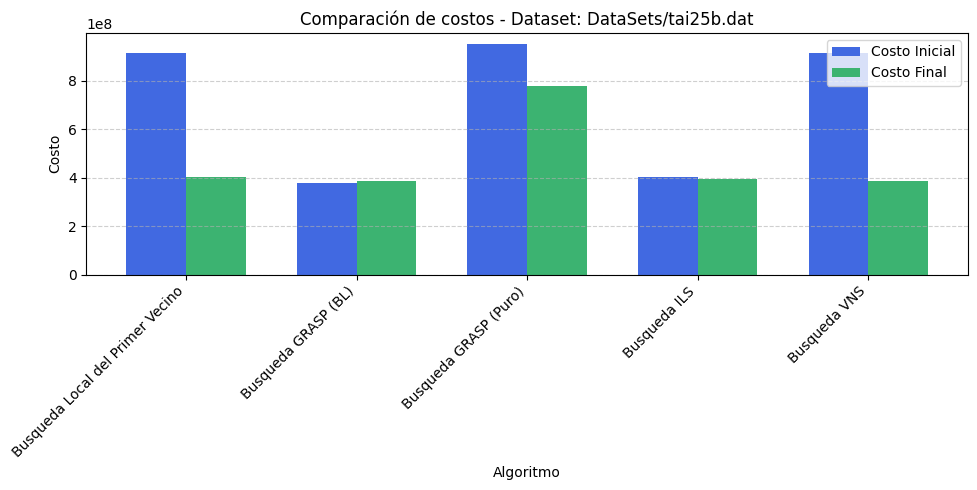

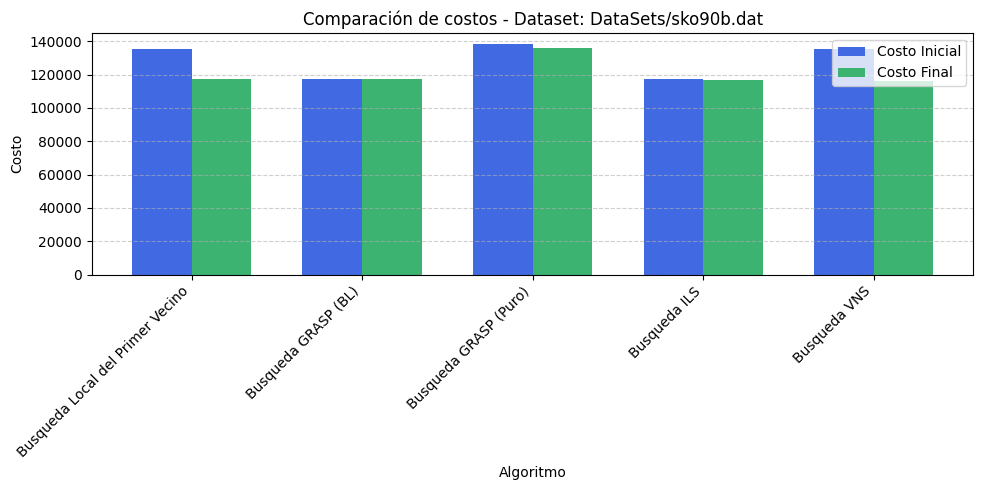

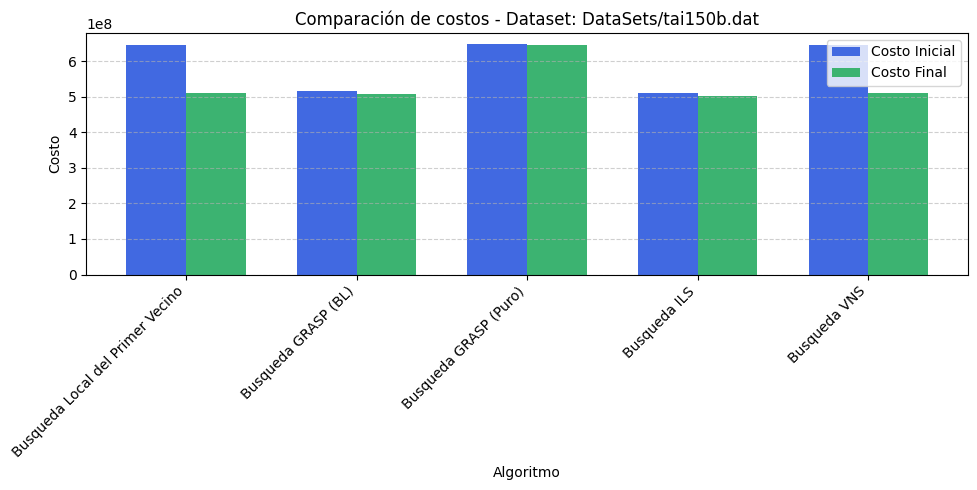

In [45]:
print("\nTablas resumen globales\n")
algoritmos_orden = ["Greedy", "Busqueda Local del Primer Vecino", "Busqueda GRASP (BL)", "Busqueda GRASP (Puro)","Busqueda ILS", "Busqueda VNS"]  # Ajusta según nombres usados
tabla_resultados_globales(resultados_en_memoria, nombre_algoritmos=algoritmos_orden)
graficar_coste_inicial_final_por_dataset(resultados_en_memoria)
